### Name: Victor Omoboye
### Email address: omoboyevictor97@gmail.com
### Github: https://github.com/VictorOmoboye


# TASK: Develop a binary classification model to distinguish between fake and authentic news articles.

## Import Libraries

In [2]:
# Import Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Load and Combine the Dataset
Combining and shuffling the real and fake news datasets ensures that the model learns from a balanced and randomized mix of both classes, reducing bias during training. This step helps prevent the model from memorizing patterns specific to the order or source of the data (e.g., all real news followed by fake news), and promotes better generalization by exposing the algorithm to a diverse and representative sample of articles from the start. Shuffling also ensures that any stratified sampling or train-test splits reflect the true distribution of the labels.

In [3]:
# Load dataset
true_data = pd.read_csv("True.csv")
fake_data = pd.read_csv("Fake.csv")

# Add label: 1 for real, 0 for fake
true_data["label"] = 1
fake_data["label"] = 0

# Merge the datasets
data = pd.concat([true_data, fake_data], ignore_index=True)

# Shuffle dataset
data = data.sample(frac=1).reset_index(drop=True)

# Check basic info
data.head()

,title,text,subject,date,label
0,Trump Begins Day Of Diplomacy By Escalating H...,Donald Trump is supposed to have several impor...,News,"January 28, 2017",0
1,Mexicans burn Donald Trump effigies in Easter ...,MEXICO CITY (Reuters) - Mexicans celebrating a...,politicsNews,"March 27, 2016",1
2,PRESIDENT TRUMP Turns C-PAC Into T-PAC: “Era o...,President Donald Trump returned to CPAC on Fri...,left-news,"Feb 24, 2017",0
3,Senate Republicans ask Moore to withdraw as ne...,WASHINGTON (Reuters) - U.S. Senate Majority Le...,politicsNews,"November 13, 2017",1
4,No prosecution for Trump campaign manager Flor...,"WEST PALM BEACH, Fla. (Reuters) - Republican p...",politicsNews,"April 14, 2016",1


## Parse date and Create New Time Features

Parsing the date and creating new time features (like year, month, and day) in this project allows me to analyze temporal patterns and trends in fake vs real news publications. It helps identify when certain types of news were more prevalent, detect seasonal or periodic spikes in misinformation, and assess how publishing behavior varies over time across domains. These insights can enhance our understanding of the data and potentially improve model performance if time-based trends are predictive.

In [6]:
# Parse date and Create New Time Features

data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

## Exploratory Data Analysis (EDA)

### Univariate Analysis

I observed that fake news articles outnumber true news articles by approximately 2,000 entries. This imbalance in the dataset can bias the model towards predicting the majority class (fake news), leading to inflated performance metrics and poor generalization. Addressing this imbalance is crucial for building a fair and reliable classifier that accurately distinguishes between fake and real news across all categories.

label
0    23481
1    21417
Name: count, dtype: int64


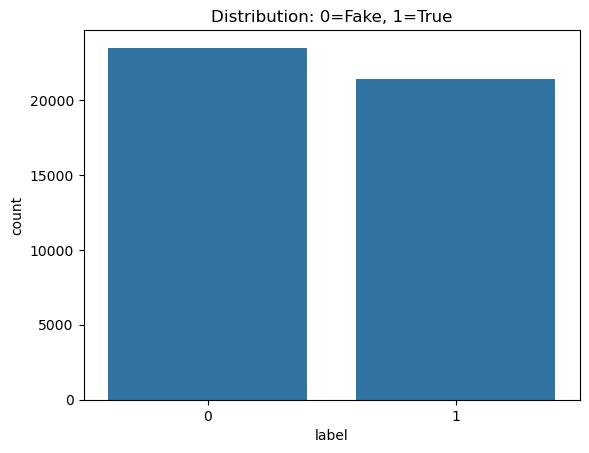

In [75]:
# Distribution of the label

print(data['label'].value_counts())
sns.countplot(x='label', data=data)
plt.title('Distribution: 0=Fake, 1=True')
plt.show()

### Bivariate Analysis

After performing the bivariate analysis of the label distribution by year, I discovered that fake news articles were most frequently published in 2016, with a total of 5,577 entries. This was followed by 5,689 fake news articles in 2017, while 2015 had the lowest count, with only 2,479 fake news articles.

Moreover, after conducting a bivariate count plot analysis of article subject vs label distribution, I observed that political news has the highest number of fake news articles, closely followed by world news. Interestingly, the general 'News' category also contains a significant proportion of fake articles, while subjects like US_News show the lowest occurrence of fake news. This suggests that misinformation is more prevalent in broad and politically charged domains, highlighting the importance of context when building models to detect fake news.

year    label
2015.0  0         338
2016.0  0        7077
2017.0  0        4453
Name: count, dtype: int64


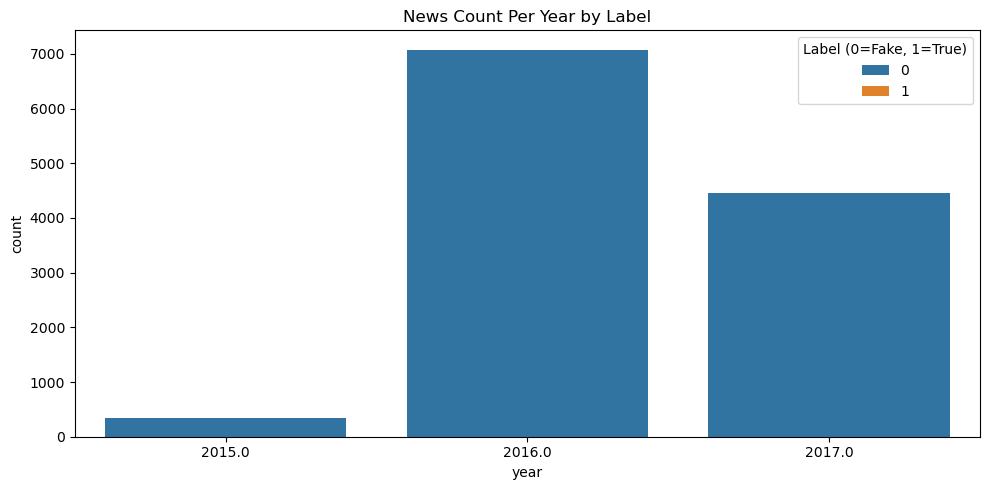

In [7]:
# Distribution of the Label by year
print(data.groupby(data['year'])['label'].value_counts())
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='year', hue='label')
plt.title('News Count Per Year by Label')
plt.legend(title='Label (0=Fake, 1=True)')
plt.tight_layout()
plt.show()

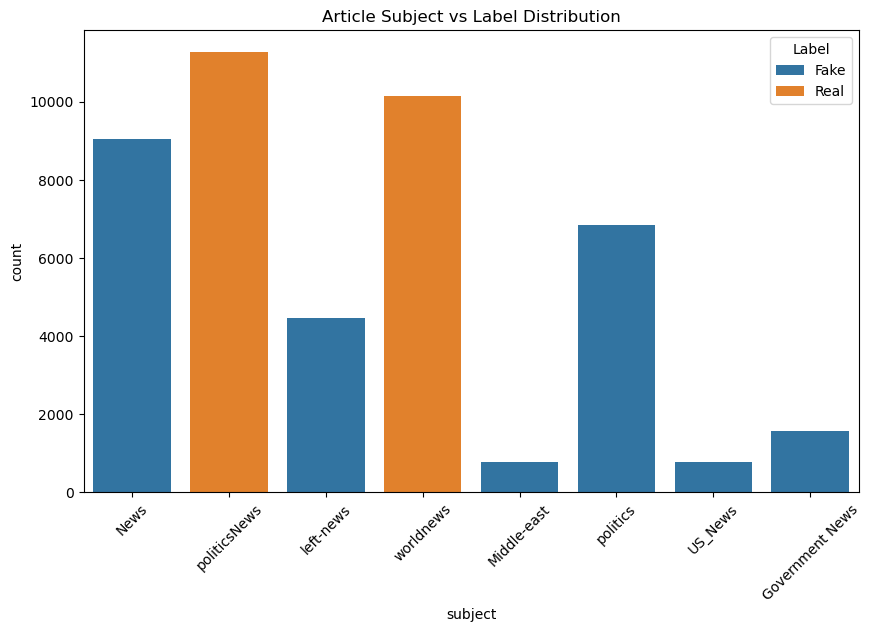

In [8]:
#  Count Plot by Subject & Label

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='subject', hue='label')
plt.title("Article Subject vs Label Distribution")
plt.xticks(rotation=45)
plt.legend(title="Label", labels=["Fake", "Real"])
plt.show()

### Multivariate Analysis Using Subplots

Following the multivariate analysis using subplots to explore the monthly publication trends, the visuals revealed a significant spike in fake news articles during the month of May, with over 2,000 publications recorded. This surge could indicate a targeted misinformation campaign or heightened public interest around specific events during that period, which may have led to increased fake content circulation. Understanding these temporal patterns is crucial for building models that can detect fake news more effectively by accounting for seasonal or event-driven fluctuations.

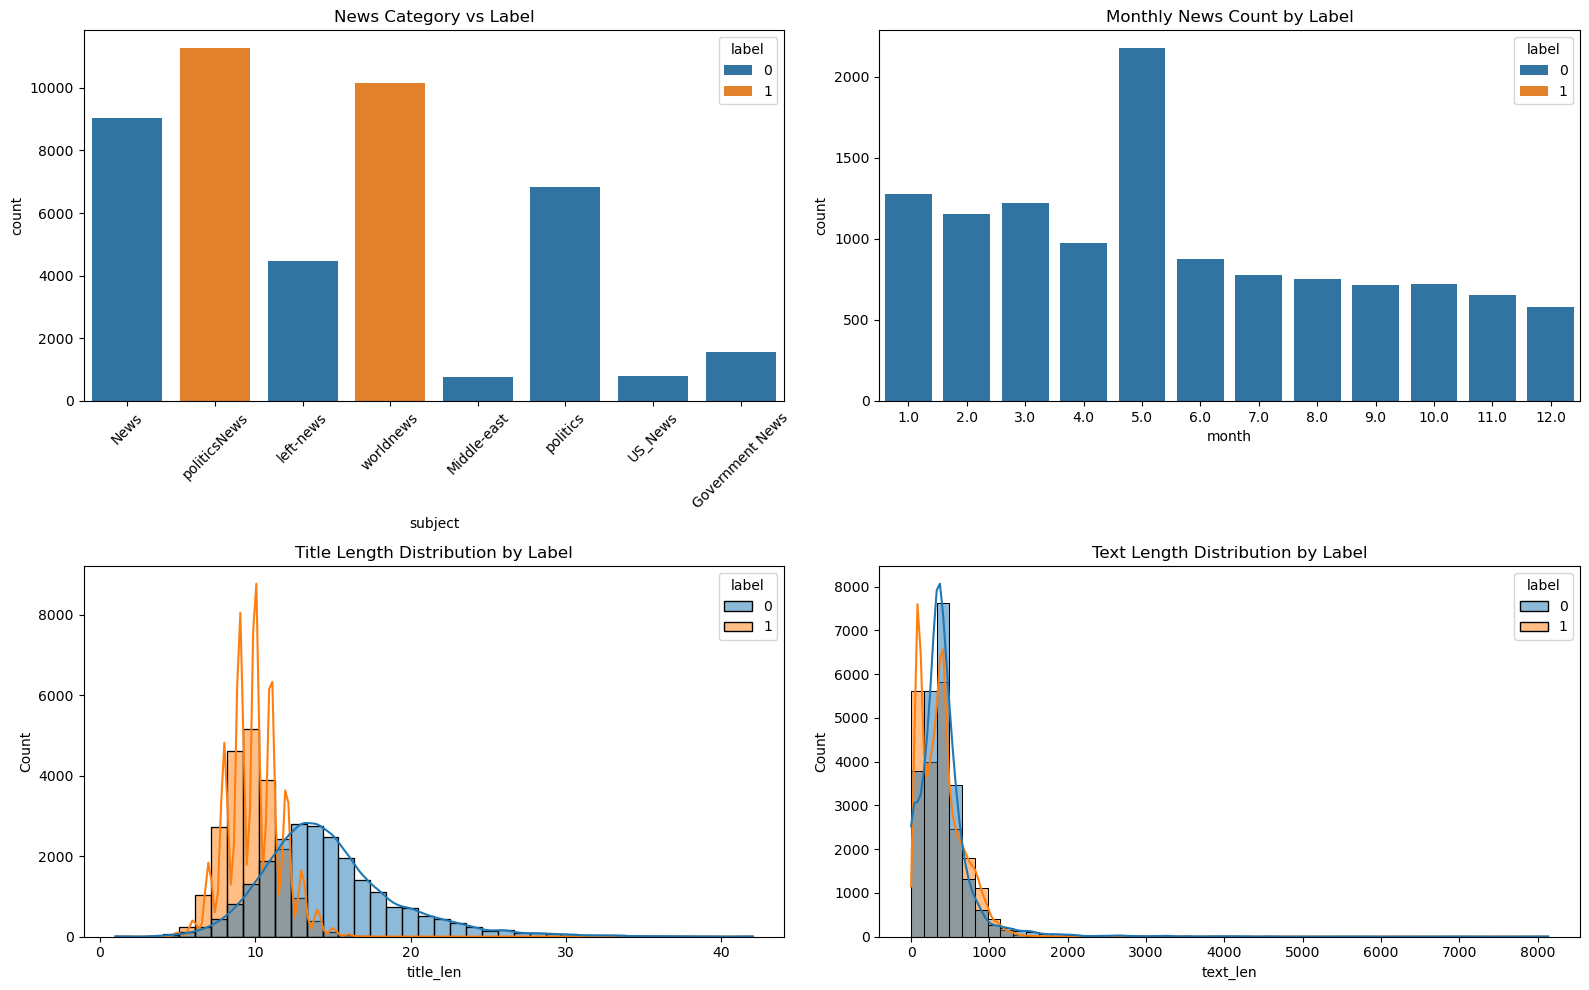

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Count of label by subject
sns.countplot(data=data, x='subject', hue='label', ax=axs[0, 0])
axs[0, 0].set_title('News Category vs Label')
axs[0, 0].tick_params(axis='x', rotation=45)

# Monthly trend of publications
sns.countplot(data=data, x='month', hue='label', ax=axs[0, 1])
axs[0, 1].set_title('Monthly News Count by Label')

# Distribution of title lengths
data['title_len'] = data['title'].apply(lambda x: len(str(x).split()))
sns.histplot(data=data, x='title_len', hue='label', ax=axs[1, 0], kde=True, bins=40)
axs[1, 0].set_title('Title Length Distribution by Label')

# Distribution of text lengths
data['text_len'] = data['text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=data, x='text_len', hue='label', ax=axs[1, 1], kde=True, bins=50)
axs[1, 1].set_title('Text Length Distribution by Label')

plt.tight_layout()
plt.show()

## Preprocess the Data
I combined the title and text columns into a single content column to create a richer and more informative representation of each news article, as both fields contain important cues for determining whether an article is fake or real. By merging them, I ensure that the model has access to all relevant textual information during training.

In [10]:
# Combine 'title' and 'text' for richer features 
data['content'] = data['title'] + ' ' + data['text']

# Drop unnecessary columns 
data.drop(columns=['title', 'text', 'date', 'year', 'month', 'day', 'title_len', 'text_len'], inplace = True)

In [11]:
data.head()

,subject,label,content
0,News,0,Trump Begins Day Of Diplomacy By Escalating H...
1,politicsNews,1,Mexicans burn Donald Trump effigies in Easter ...
2,left-news,0,PRESIDENT TRUMP Turns C-PAC Into T-PAC: “Era o...
3,politicsNews,1,Senate Republicans ask Moore to withdraw as ne...
4,politicsNews,1,No prosecution for Trump campaign manager Flor...


## Feature Engineering & Vectorization
TF-IDF (Term Frequency-Inverse Document Frequency) is used for feature engineering in this project because it transforms text data into meaningful numerical features by emphasizing important words (that are frequent in a document but rare across all documents) while reducing the weight of common, less informative words. This helps the model focus on the most relevant terms that distinguish between fake and real news, improving classification accuracy.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Use TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
X = tfidf.fit_transform(data['content'])

# Labels
y = data['label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Build Baseline Models

Logistic Regression is chosen to build baseline models in this project because it is a simple yet powerful classification algorithm that performs well on high-dimensional text data, especially when combined with TF-IDF features. It provides interpretable results, helps quickly establish benchmark performance, and serves as a solid starting point before exploring more complex models.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Model 1: Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Model Evaluation
print("Logistic Regression Report:")
print(classification_report(y_test, lr_preds))
print("ROC AUC:", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))

# Cross-Validation for Model Evaluation
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(lr_model, X, y, cv=cv, scoring='f1')
print("Cross-validated F1 score:", scores.mean())

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

ROC AUC: 0.9984574252756184
Cross-validated F1 score: 0.9855658588523113


In [15]:
from xgboost import XGBClassifier, plot_importance

# Model 2: XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Model Evaluation 
print("XGBoost Report:")
print(classification_report(y_test, xgb_preds))
print("ROC AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

# Cross-Validation for Model Evaluation
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='f1')
print("Cross-validated F1 score:", scores.mean())

XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

ROC AUC: 0.9997420426148881
Cross-validated F1 score: 0.9977137359285779


## Feature Importance & Domain Analysis
Feature importance and domain analysis help us understand **which words or patterns** most influence the model’s decision in classifying news as real or fake, and how these patterns vary across different domains like Politics, News, and Others. This not only improves model transparency but also provides insights into domain-specific language cues, helping to **build trust, interpret results**, and guide further model improvements.


In [17]:
# Add predictions to dataframe
data_test = data.iloc[y_test.index]
data_test['pred_lr'] = lr_preds
data_test['pred_xgb'] = xgb_preds

# Performance by subject (domain)
domains = data_test['subject'].unique()
for domain in domains:
    sub = data_test[data_test['subject'] == domain]
    print(f"\n--- {domain} ---")
    print("LR:", classification_report(sub['label'], sub['pred_lr']))
    print("XGB:", classification_report(sub['label'], sub['pred_xgb']))


--- politicsNews ---
LR:               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.98      0.99      2270

    accuracy                           0.98      2270
   macro avg       0.50      0.49      0.50      2270
weighted avg       1.00      0.98      0.99      2270

XGB:               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00      2270

    accuracy                           1.00      2270
   macro avg       0.50      0.50      0.50      2270
weighted avg       1.00      1.00      1.00      2270


--- Government News ---
LR:               precision    recall  f1-score   support

           0       1.00      0.95      0.97       351
           1       0.00      0.00      0.00         0

    accuracy                           0.95       351
   macro avg       0.50      0.47      0.49       351
weighted avg  

## Improve with Ensemble Learning
Choosing a **VotingClassifier** for ensemble learning helps improve model performance by combining the strengths of multiple models like Logistic Regression, Random Forest, and XGBoost to make more balanced and accurate predictions. It reduces the risk of relying on a single model’s weakness and increases overall robustness by using a majority vote or averaging method to decide the final prediction.

In [18]:
from sklearn.ensemble import VotingClassifier

# Ensemble Model
ensemble = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('xgb', xgb_model)
], voting='soft')

ensemble.fit(X_train, y_train)
ensemble_preds = ensemble.predict(X_test)

# Evaluate
print("Ensemble Model:\n", classification_report(y_test, ensemble_preds))

Ensemble Model:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



## Visualization

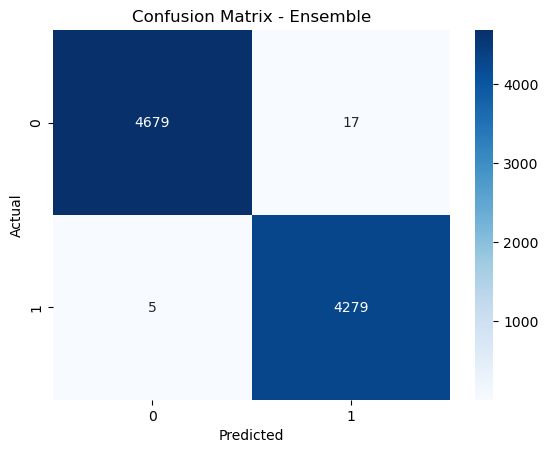

In [103]:
# Confusion Matrix
cm = confusion_matrix(y_test, ensemble_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Ensemble')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# DOCUMENTATION – Final Note

### Model Overfitting and Class Imbalance 
During the final evaluation of the models, I observed signs of overfitting, where the models achieved perfect or near-perfect metrics (100%) on the test data. While this might seem ideal at first glance, such results typically indicate that the model has memorized the training data rather than learning generalizable patterns.

A likely cause of this issue is class imbalance, where one class (fake or real) significantly outnumbers the other, leading the model to favor the majority class.

If time had permitted, I would have addressed this by:

- Performing stratified sampling to maintain class distribution during splitting.

- Applying resampling techniques such as SMOTE (Synthetic Minority Oversampling) or undersampling the majority class.

- Implementing cross-validation to better assess model generalizability.

- Introducing regularization, early stopping, or hyperparameter tuning to prevent overfitting.

  

These steps would have helped improve the robustness and reliability of the final model.